# Imports

In [1]:
import datetime
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from src.datasets.pneumonia_detection_challenge import PneumoniaDetectionChallenge
from src.datasets.chest_xray import ChestXRay
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [2]:
IMAGE_SIZE = (256, 256)

In [3]:
cx = ChestXRay(DATASET_CHEST_XRAY_PATH, IMAGE_SIZE)

In [4]:
Scheme.dataset_info(cx)

Train:
 - Normal: 1341
 - Pneumonia: 1938
Test:
 - Normal: 234
 - Pneumonia: 390
Val:
 - Normal: 8
 - Pneumonia: 8


In [5]:
x_train, y_train, _ = cx.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = cx.load_val_data()
x_val = x_val / 255.0

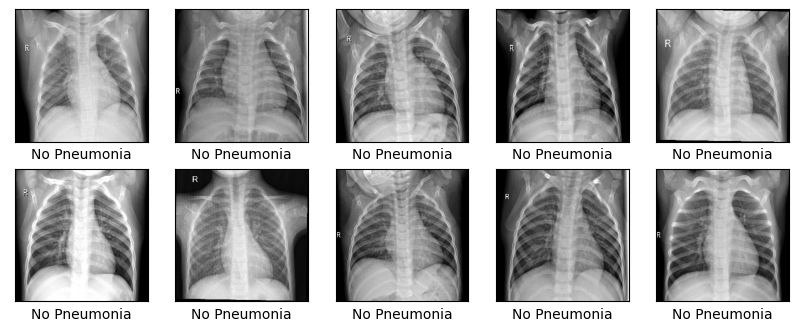

In [6]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [7]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [8]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [9]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(64),
        conv_block(128),
        conv_block(256),
        conv_block(256),

        tf.keras.layers.Flatten(),
        dense_block(516, 0.2),
        dense_block(256, 0.2),
        dense_block(128, 0.2),
        dense_block(64, 0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [10]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 64)        31168     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 128)       123776    
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 256)       493312    
_________________________________________________________________
sequential_3 (Sequential)    (None, 8, 8, 256)        

In [11]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [12]:
aug = ImageDataGenerator(rotation_range=45, zoom_range=0.3,
						width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
						vertical_flip=True, horizontal_flip=True, fill_mode="nearest")

history = model.fit(aug.flow(x_train, y_train, batch_size=16),
					validation_data=(x_val, y_val),
					epochs=30)

Epoch 1/30
205/205 [==============================] - 35s 154ms/step - loss: 0.6056 - binary_accuracy: 0.7059 - precision: 0.7755 - recall: 0.7002 - val_loss: 2.9581 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
205/205 [==============================] - 30s 145ms/step - loss: 0.3904 - binary_accuracy: 0.8219 - precision: 0.8482 - recall: 0.8484 - val_loss: 3.8390 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
205/205 [==============================] - 30s 145ms/step - loss: 0.3556 - binary_accuracy: 0.8490 - precision: 0.8821 - recall: 0.8556 - val_loss: 1.9321 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
205/205 [==============================] - 30s 146ms/step - loss: 0.3277 - binary_accuracy: 0.8706 - precision: 0.8929 - recall: 0.8845 - val_loss: 1.3258 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/30
205/205 [================

<Figure size 640x480 with 0 Axes>

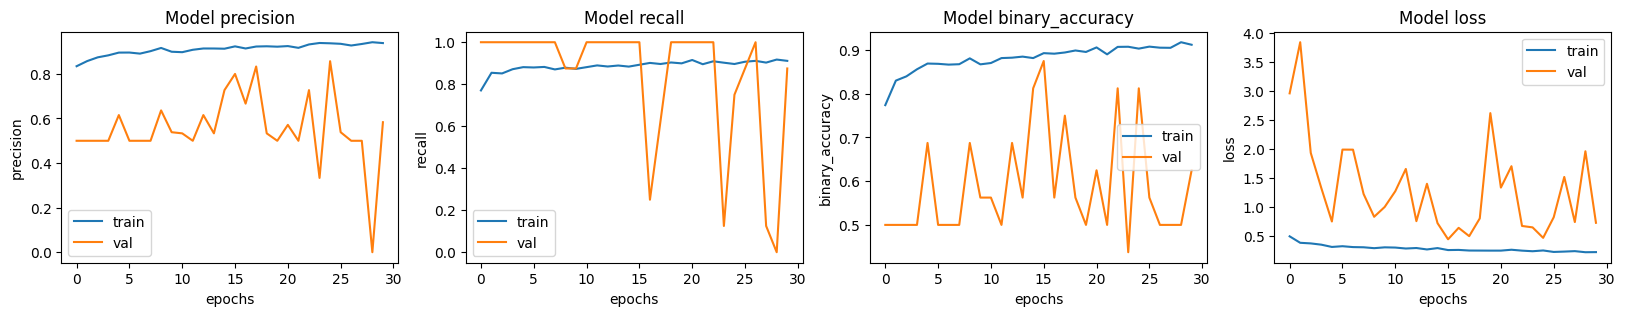

In [13]:
Scheme.training_graphs(history)

In [14]:
del x_train
del y_train

In [15]:
time = str(datetime.datetime.now().strftime("%d%m%Y%H%M%S"))

model_json = model.to_json()
with open("models/" + "cxv_" + time + ".json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("models/" + "cxv_" + time + ".h5")
print("cxv_" + time)

cxv_17022022193333


# Evaluating the model

### Chest X-Ray

In [16]:
x_test, y_test, images = cx.load_test_data()
x_test = x_test / 255.0

In [17]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

20/20 [==============================] - 2s 52ms/step - loss: 0.4037 - binary_accuracy: 0.8333 - precision: 0.8611 - recall: 0.8744


In [18]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [19]:
images_index = [9, 11, 12, 13, 16, 1, 2, 3, 5, 8]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

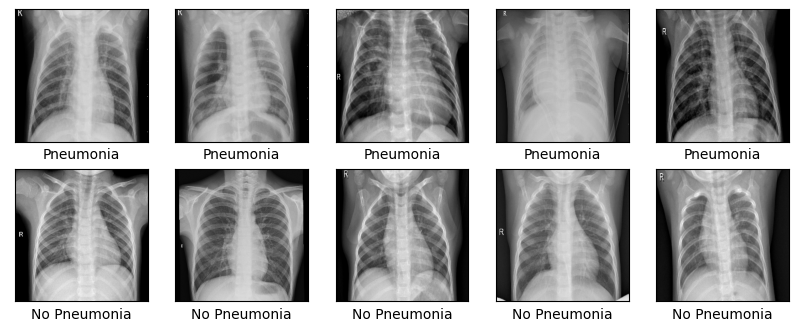

In [20]:
Scheme.labeled_images(images, labels)

Explain the images

In [21]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:08<00:00, 117.03it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

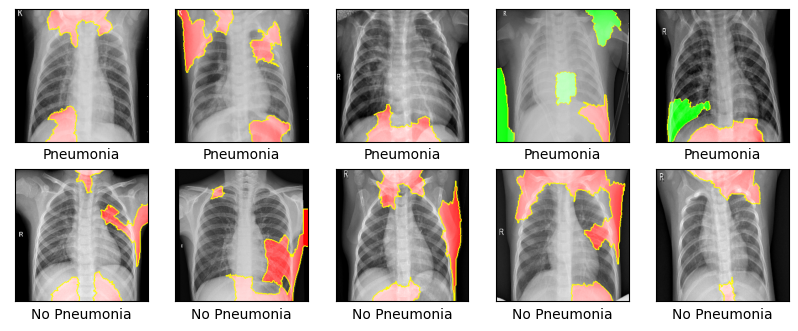

In [22]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

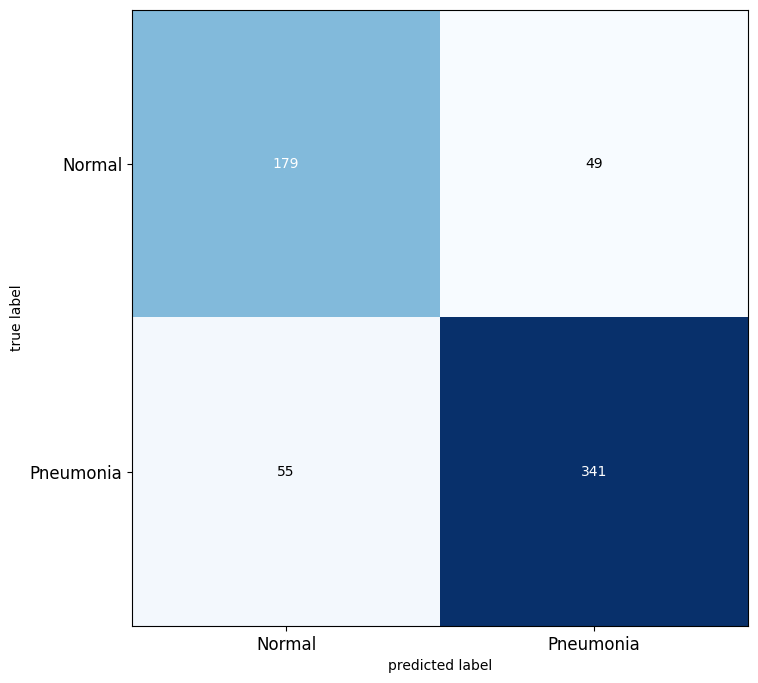

In [23]:
Scheme.confusion_matrix(predictions_rounded, cx.get_test_df().diagnosis.to_numpy())

### Pneumonia Detection Challenge

In [24]:
pdc = PneumoniaDetectionChallenge(DATASET_PNEUMONIA_DETECTION_CHALLENGE_PATH, IMAGE_SIZE)
x_test, y_test, images = pdc.load_test_data()
x_test = x_test / 255.0

In [25]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

95/95 [==============================] - 6s 59ms/step - loss: 1.1030 - binary_accuracy: 0.6612 - precision: 0.6354 - recall: 0.7121


In [26]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [27]:
images_index = [103, 117, 156, 353, 465, 1615, 1707, 1875, 1951, 2150]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

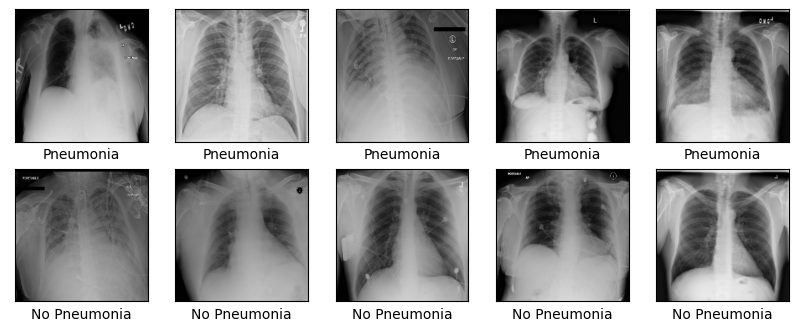

In [28]:
Scheme.labeled_images(images, labels)

Explain the images

In [29]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:08<00:00, 118.09it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

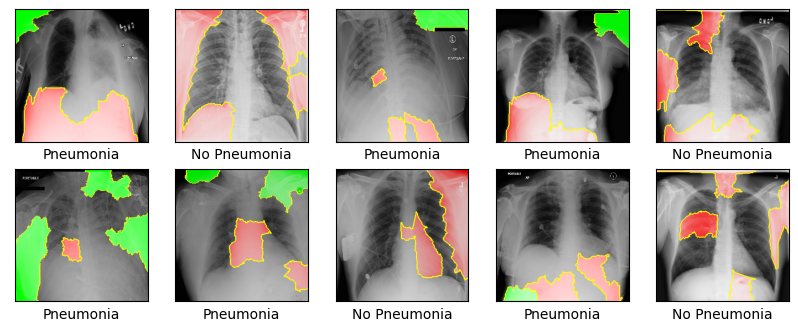

In [30]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

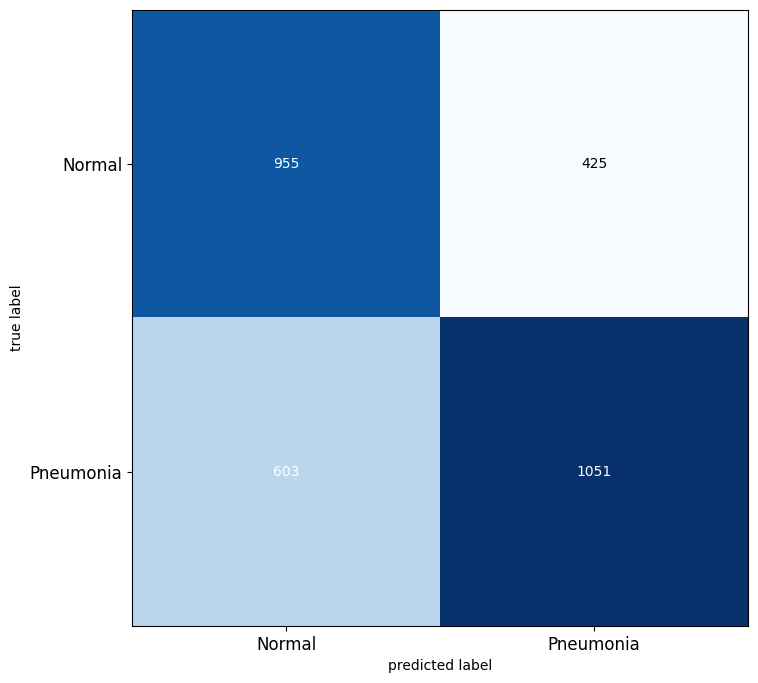

In [31]:
Scheme.confusion_matrix(predictions_rounded, pdc.get_test_df(). diagnosis.to_numpy())